#INFO204 Assignment 3: Supervised Learning Problem
---
*Jackson Kerr | 2942576*

[GitHub Repo](https://github.com/JacksonKerr/LinearRegression)

---



In [1]:
fast = True         # If true, uses stored graph images from GitHub repo for speed

## Setup:
Imports and helper functions.

#### Imports:

In [2]:
# Data Manipulation and Display
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# Sklearn
from sklearn import datasets
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, r2_score, mean_squared_error

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

# TF Neural Network Stuff
import tensorflow as tf
from keras import models
from keras import layers
from keras import optimizers

# Set up resources for training neural network
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))
strategy = tf.distribute.TPUStrategy(resolver)


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.9.220.194:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.9.220.194:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]
INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


#### Helper functions from labs
- extract_loadings(pca, feature_names=None, pipeline_component=None, prefix='PC')
- biplot(X, loadings=None, pc1=0, pc2=1, y=None, labels=None)

In [3]:
def extract_loadings(pca, feature_names=None, pipeline_component=None, prefix='PC'):
    """
       take a PCA model and extract its loadings into a data frame for easier interrogation
    """
    if pipeline_component is not None:
        pca = pca[pipeline_component]
        
    X = pca.components_.T
    
    return pd.DataFrame(X, columns=[ f'{prefix}{i+1}' for i in range(X.shape[1]) ], index=feature_names)

In [4]:
def biplot(X, loadings=None, pc1=0, pc2=1, y=None, labels=None):
    """
      plot two principal components of data embedded via PCA along with their feature loadings
    """
    xs = X[:, pc1]
    ys = X[:, pc2]
    
    scalex = 1.0 / (xs.max() - xs.min())
    scaley = 1.0 / (ys.max() - ys.min())    
    sns.scatterplot(x=xs*scalex, y=ys*scaley, hue=y, palette='viridis')
    
    if loadings is not None:
        n = len(loadings)
        if labels is None:
            labels = loadings.index.values
        for i in range(n):
            plt.arrow(0, 0, loadings.iloc[i, pc1], loadings.iloc[i, pc2], color='#ce2227', width=0.01, head_width=0.04)
            plt.text(loadings.iloc[i, pc1]* 1.15, loadings.iloc[i, pc2] * 1.15, labels[i], color='#ce2227', ha='center', va='center')
        
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel(f'PC{pc1+1}')
    plt.ylabel(f'PC{pc2+1}')
    plt.grid()

In [5]:
def screeplot(pca, pipeline_component=None, prefix='PC', n_components=None):
    """
        produce a plot from a PCA embedding that visualises the amount of 
        explained variance for each of the principal components 
    """
    
    if pipeline_component is not None:
        pca = pca[pipeline_component]

    explained_variance = pca.explained_variance_ratio_
    if n_components is not None: explained_variance = explained_variance[0:n_components]
    
    total_variance = np.cumsum(explained_variance)
    ticks = range(len(explained_variance))
    labels = [ f'{prefix}{i+1}' for i in ticks ]

    plt.bar(x=range(len(explained_variance)), height=explained_variance, label='Component')
    plt.plot(range(len(total_variance)), total_variance, 'o-', color='#ce2227', linewidth=2, label='Cumulative')
    plt.xticks(ticks=ticks, labels=labels)
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance')
    plt.legend()

    return total_variance # Modification, return for examination

##Gettin That Data:



In [6]:
mystery_df = pd.read_csv(
    'https://raw.githubusercontent.com/JacksonKerr/LinearRegression/main/Assignment3/Supervised_Learning/mystery_train.csv',
    index_col=0).reset_index()

In [7]:
display(mystery_df.head())

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,y
0,72.0,0.0,0.00772,0.000040,0.00437,0.00420,0.01310,0.05514,0.506,0.03163,0.03072,0.03860,0.09490,0.018124,20.744,0.41898,0.54621,0.218980,37.363
1,56.0,1.0,0.00282,0.000012,0.00147,0.00163,0.00442,0.01663,0.154,0.00844,0.01095,0.01326,0.02531,0.012180,24.357,0.37512,0.54592,0.089372,45.866
2,74.0,1.0,0.01069,0.000057,0.00623,0.00549,0.01870,0.03469,0.304,0.01677,0.01865,0.03069,0.05032,0.017158,19.843,0.55488,0.74074,0.294060,30.929
3,66.0,1.0,0.00403,0.000018,0.00209,0.00225,0.00627,0.01644,0.146,0.00847,0.00992,0.01271,0.02540,0.016296,23.011,0.45830,0.55130,0.178600,39.738
4,73.0,0.0,0.00556,0.000044,0.00257,0.00267,0.00772,0.03634,0.362,0.01872,0.02303,0.03365,0.05615,0.030850,19.422,0.51665,0.63427,0.353550,40.688


All seem to be continuous values, except for x2, let's have a look at it.

In [8]:
display(set(mystery_df["x2"]))

{0.0, 1.0}

Only contains two unique values. Likely a categorical variable.

Let's have a look at the fields.

In [9]:
mystery_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      5000 non-null   float64
 1   x2      5000 non-null   float64
 2   x3      5000 non-null   float64
 3   x4      5000 non-null   float64
 4   x5      5000 non-null   float64
 5   x6      5000 non-null   float64
 6   x7      5000 non-null   float64
 7   x8      5000 non-null   float64
 8   x9      5000 non-null   float64
 9   x10     5000 non-null   float64
 10  x11     5000 non-null   float64
 11  x12     5000 non-null   float64
 12  x13     5000 non-null   float64
 13  x14     5000 non-null   float64
 14  x15     5000 non-null   float64
 15  x16     5000 non-null   float64
 16  x17     5000 non-null   float64
 17  x18     5000 non-null   float64
 18  y       5000 non-null   float64
dtypes: float64(19)
memory usage: 742.3 KB


Looks pretty standard. No missing values. All float64 decimal numbers.

## Exploratory Data Analysis

### Pairplot

Let's look at the relationships between the variables using hue="x2" as it's the only categorical variable.

In [10]:
if fast:
  # Get stored pairplot from GitHub repo
  from IPython.display import Image
  from IPython.core.display import HTML 
  img = Image(url= "https://raw.githubusercontent.com/JacksonKerr/LinearRegression/main/Assignment3/Supervised_Learning/pairplot.png")
else:
  # Create directly
  img = sns.pairplot(mystery_df, hue="x2")
img

### Correlations:

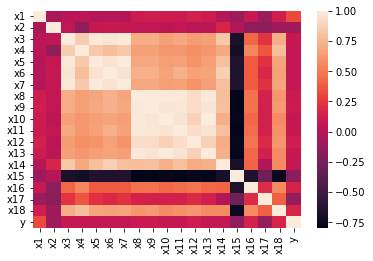

In [11]:
sns.heatmap(mystery_df.corr())

### Adjustments:

In [12]:
eda_ops = [] # Stores all operations done on the data during EDA so they can later performed on test data

First, let's remove some of the very highly correlated variables. For each of them neither seems to be more correlated with the output than the other so they have been removed mostly at random.

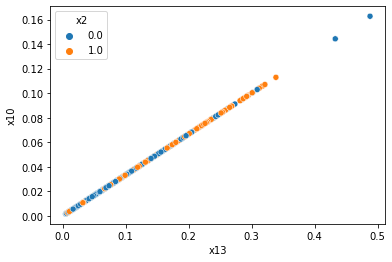

In [13]:
sns.scatterplot(x=mystery_df["x13"], y=mystery_df["x10"], hue=mystery_df["x2"])
# Remove one
def rem13(data):
  to_rem = "x13"
  return data.drop([to_rem], axis=1)
mystery_df = rem13(mystery_df)
eda_ops.append(rem13)

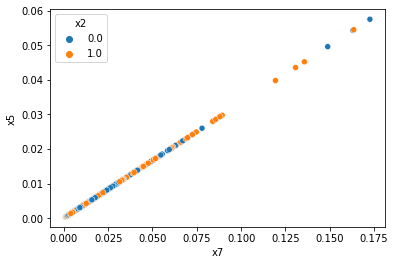

In [14]:
sns.scatterplot(x=mystery_df["x7"], y=mystery_df["x5"], hue=mystery_df["x2"])
def rem7(data):
  to_rem = "x7"
  return data.drop([to_rem], axis=1)
mystery_df = rem7(mystery_df)
eda_ops.append(rem7)

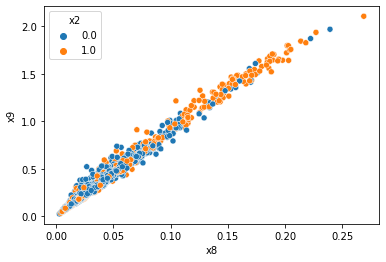

In [15]:
sns.scatterplot(x=mystery_df["x8"], y=mystery_df["x9"], hue=mystery_df["x2"])
# Remove one
def rem8(data):
  to_rem = "x8"
  return data.drop([to_rem], axis=1)
mystery_df = rem8(mystery_df)
eda_ops.append(rem8)

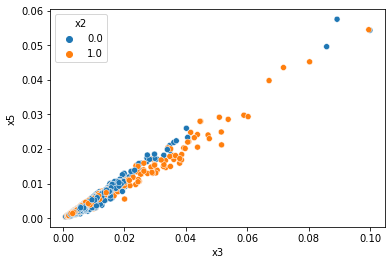

In [16]:
sns.scatterplot(x=mystery_df["x3"], y=mystery_df["x5"], hue=mystery_df["x2"])
# Remove one
def rem3(data):
  to_rem = "x3"
  return data.drop([to_rem], axis=1)
mystery_df = rem3(mystery_df)
eda_ops.append(rem3)

x15 seems to have a non-linear relationship with many other features. By scaling we can make it more linear.

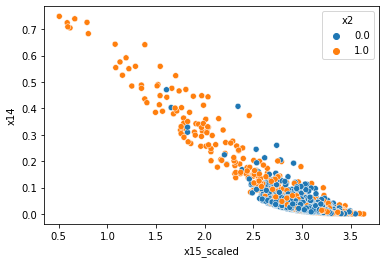

In [17]:
def scale15(data):
    data.insert(2, "x15_scaled", np.log(data["x15"].copy()), True)
    return data.drop(["x15"], axis=1)
mystery_df = scale15(mystery_df)
eda_ops.append(scale15)
sns.scatterplot(x=mystery_df["x15_scaled"], y=mystery_df["x14"], hue=mystery_df["x2"])

Looking more linear now

### A Look at Our Changes:

In [18]:
if fast:
  # Get stored pairplot from GitHub repo
  from IPython.display import Image
  from IPython.core.display import HTML 
  img = Image(url= "https://raw.githubusercontent.com/JacksonKerr/LinearRegression/main/Assignment3/Supervised_Learning/pairplot2.png")
else:
  # Create directly
  img = sns.pairplot(mystery_df, hue="x2")
img

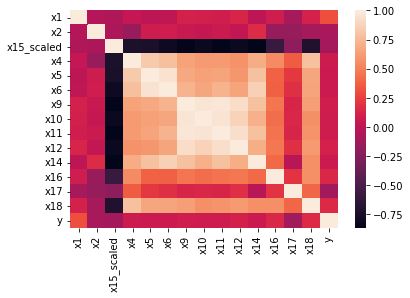

In [19]:
sns.heatmap(mystery_df.corr())

There are still a few variables which are correlated with eachother. However, after eyballing their relationships, they look maybe just different enough that removing them from the dataset may harm our predictions.

### PCA Analysis

By 9 principal components, we have accounted for 99.049% of the variance in the data.


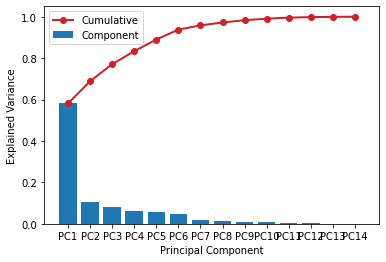

In [20]:
def find_optimal_pca_components():
  pca = PCA()
  pca_pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca)])
  P = pca_pipe.fit_transform(mystery_df.drop("y", axis=1))

  # Draw screeplot
  pca_performance = screeplot(pca)

  # Print number of components needed to account for most of the variation
  optimal_components = None
  for i in range(len(pca_performance)):
    if pca_performance[i] > 0.99:
      optimal_components = i
      print("By", i, "principal components, we have accounted for",
            str(round(pca_performance[i]*100, 3)) + "%", "of the variance in the data.")
      break
  return optimal_components
optimal_pca_components = find_optimal_pca_components()

In [21]:
# Apply PCA with optimal components to data
pca = PCA(optimal_pca_components)
optimal_pca_pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca)])

P = optimal_pca_pipe.fit_transform(mystery_df.drop("y", axis=1))
mystery_x_pca = pd.DataFrame(P)
mystery_x_pca.columns = ["PC"+str(i+1) for i in range(len(mystery_x_pca.columns))]

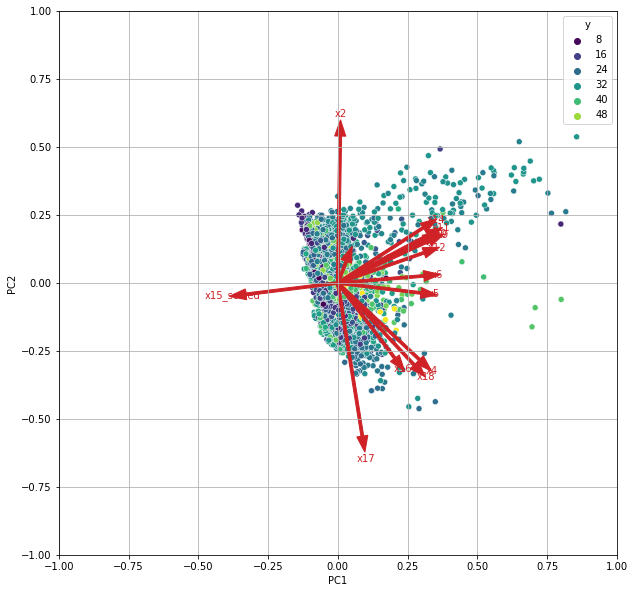

In [22]:
# Biplot
fig = plt.figure(figsize=(10, 10))
biplot(P, extract_loadings(pca, feature_names=mystery_df.drop("y", axis=1).columns), y=mystery_df["y"])
plt.show()

## Modeling:

In [23]:
mystery_xy = mystery_df.copy()
mystery_y = mystery_xy['y']
mystery_x = mystery_xy.drop(labels=['y'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(mystery_x, mystery_y, train_size=0.9, random_state=1)

Here we create a pipeline and perform a gridsearch over many different variables.

In [24]:
pipe = Pipeline([("pca", "passthrough"), ("mdl", "passthrough")])

pca_options = ([PCA(optimal_pca_components)])
mdl_options = ([LinearRegression()]
            + [MLPRegressor(n) for n in [ 1, 2, 4, 6, 11, 19, 33, 59, 106, 189, 200, 223, 250]]
            + [KNeighborsRegressor(n) for n in range(1, 20)]
            + [DecisionTreeRegressor(n) for n in range(2, 15)])

tune_grids = [{'pca':pca_options, 'mdl': mdl_options}]

rkf = RepeatedKFold(n_splits=3, n_repeats=5)

scorer = make_scorer(r2_score, greater_is_better=True)

cv = GridSearchCV(pipe, tune_grids, cv=rkf, scoring=scorer, n_jobs=-1, verbose=1).fit(x_train, y_train)

Fitting 15 folds for each of 46 candidates, totalling 690 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 370 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 690 out of 690 | elapsed:   22.8s finished


Let's examine the results...

In [25]:
pred = cv.best_estimator_.predict(x_test)
cv_r2 = r2_score(y_test, pred)
from tabulate import tabulate
import inspect
print("==== Final Scores ====")
table = [[cv.best_params_["mdl"].__class__.__name__,
          float(mean_squared_error(y_test, pred)),
          cv_r2]]

for i in range(len(table)):
  for j in range(len(table[i])):
    if type(table[i][j]) == float:
      table[i][j] = round(table[i][j], 3)

cv_table = tabulate(table, headers=["Best Model", "mse", "r2"])
print(cv_table)

==== Final Scores ====
Best Model              mse        r2
-------------------  ------  --------
KNeighborsRegressor  10.731  0.897251


Not too bad.

## Modeling: Deep Learning Approach

Why don't we throw a neural network at the problem to see if it'll perform better. Just a simple sequential tf one.

In [26]:
# Do PCA on data using optimal components as found earlier.
nnet_transform = PCA(optimal_pca_components)
new_my_x = pd.DataFrame(nnet_transform.fit_transform(mystery_x))
new_my_x.columns = [i for i in range(len(new_my_x.columns))]

x_leftover, x_test, y_leftover, y_test = train_test_split(new_my_x, mystery_y, train_size=0.90, random_state=1)
x_train, x_validation, y_train, y_validation = train_test_split(x_leftover, y_leftover, train_size=0.90, random_state=1)

### Helper Functions

In [27]:
def plot_network_performance(hist, lim1, lim2, figsize):
  history_dict = hist.history
  loss_values = history_dict['loss']
  val_loss_values = history_dict['val_loss']
  accuracy = history_dict['mae']
  val_accuracy = history_dict['val_mae']
  
  epochs = range(1, len(loss_values) + 1)
  fig, ax = plt.subplots(1, 1, figsize=figsize)
  #
  # Plot the model accuracy (MAE) vs Epochs
  #
  ax.plot(epochs, accuracy, 'bo', label='Training accuracy')
  ax.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
  ax.set_title('Training & Validation Accuracy', fontsize=16)
  ax.set_xlabel('Epochs', fontsize=16)
  ax.set_ylabel('Accuracy', fontsize=16)
  ax.legend()
  ax.set_ylim(lim1, lim2)

In [28]:
def calculate_scores(mdl, x_train, y_train, x_validation, y_validation, x_test, y_test):
  # Training Scores
  pred = mdl.predict(x_train)
  train_r2 = r2_score(y_train, pred)
  train_mse = mean_squared_error(y_train, pred)

  # Validation Scores
  pred = mdl.predict(x_validation)
  validation_r2 = r2_score(y_validation, pred)
  validation_mse = mean_squared_error(y_validation, pred)

  # Testing Scores
  pred = mdl.predict(x_test)
  test_r2 = r2_score(y_test, pred)
  test_mse = mean_squared_error(y_test, pred)

  return train_mse, train_r2, validation_mse, validation_r2, test_mse, test_r2

In [29]:
from keras.callbacks import Callback
class EarlyStoppingByLossVal(Callback): # Stolen callback class from stackoverflow
  def __init__(self, monitor='val_loss', value=0.00001, verbose=0):
      super(Callback, self).__init__()
      self.monitor = monitor
      self.value = value
      self.verbose = verbose

  def on_epoch_end(self, epoch, logs={}):
      current = logs.get(self.monitor)
      if current is None: warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)
      elif current < self.value:
          if self.verbose > 0: print("Epoch %05d: early stopping THR" % epoch)
          self.model.stop_training = True


def neural_network(learn_rate, num_epochs, batch_size, strat=strategy, verbose=1,  acceptable_loss=0):
  # Define Sequential model with 3 layers
  with strat.scope():
    model = tf.keras.models.Sequential(
        [
            layers.Dense(25, activation='relu', input_shape=(len(x_train.columns),)),
            layers.Dense(100, activation="relu", name="layer1"),
            layers.Dense(100, activation="relu", name="layer2"),
            layers.Dense(100, activation="relu", name="layer3"),
            layers.Dense(100, activation="relu", name="layer4"),
            layers.Dense(100, activation="relu", name="layer5"),
            layers.Dense(100, activation="relu", name="layer6"),
            layers.Dense(100, activation="relu", name="layer7"),
            layers.Dense(100, activation="relu", name="layer8"),
            layers.Dense(100, activation="relu", name="layer9"),
            layers.Dense(100, activation="relu", name="layer10"),
            layers.Dense(100, activation="relu", name="layer11"),
            layers.Dense(100, activation="relu", name="layer12"),
            layers.Dense(100, activation="relu", name="layer13"),
            layers.Dense(100, activation="relu", name="layer14"),
            layers.Dense(100, activation="relu", name="layer15"),
            layers.Dense(1, name="layer16"),
        ]
    )
    model.compile(optimizer="adam", loss='mse', metrics=['mae'])
    callbacks = [EarlyStoppingByLossVal(monitor='val_loss', value=acceptable_loss, verbose=verbose)]
    history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), 
              epochs=num_epochs, batch_size=batch_size, verbose=verbose, callbacks=callbacks)
  return model, history

### Training:


In [30]:
#                                  LRate,    # epochs, batch_size           Stop once val_loss <
nn_model, history = neural_network(0.000005, 400,      80,        strategy, acceptable_loss=9.75, verbose=1)

Epoch 1/400
Instructions for updating:
use `experimental_local_results` instead.


Instructions for updating:
use `experimental_local_results` instead.


 5/51 [=>............................] - ETA: 0s - loss: 1020.0068 - mae: 30.0054 WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0021s vs `on_train_batch_end` time: 0.3887s). Check your callbacks.


51/51 [==============================] - 12s 99ms/step - loss: 483.4261 - mae: 17.8462 - val_loss: 214.7088 - val_mae: 10.6771
Epoch 2/400
51/51 [==============================] - 1s 29ms/step - loss: 132.7686 - mae: 9.1179 - val_loss: 82.3574 - val_mae: 7.1803
Epoch 3/400
51/51 [==============================] - 1s 28ms/step - loss: 92.7489 - mae: 7.8073 - val_loss: 71.1872 - val_mae: 6.8236
Epoch 4/400
51/51 [==============================] - 1s 28ms/step - loss: 78.5014 - mae: 7.1009 - val_loss: 72.7863 - val_mae: 7.0321
Epoch 5/400
51/51 [==============================] - 1s 29ms/step - loss: 73.3415 - mae: 6.8073 - val_loss: 73.9363 - val_mae: 7.0453
Epoch 6/400
51/51 [==============================] - 2s 33ms/step - loss: 71.9491 - mae: 6.7344 - val_loss: 63.9235 - val_mae: 6.4180
Epoch 7/400
51/51 [==============================] - 1s 29ms/step - loss: 64.8064 - mae: 6.3462 - val_loss: 56.2553 - val_mae: 5.8584
Epoch 8/400
51/51 [==============================] - 1s 29ms/step - 

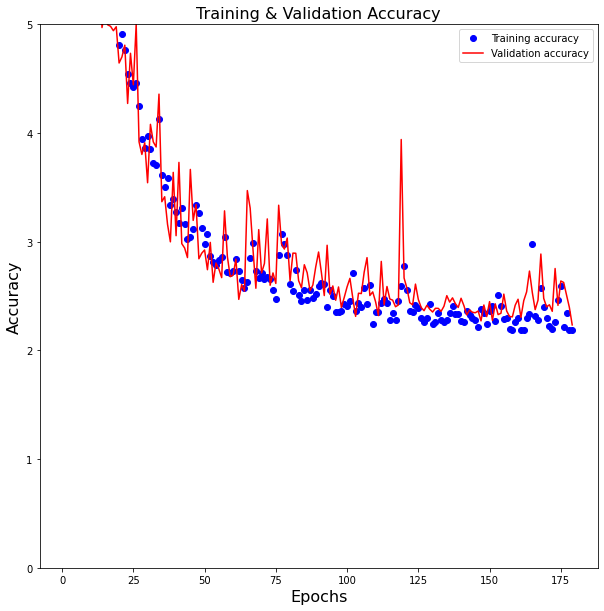

In [31]:
plot_network_performance(history, 0, 5, (10, 10))

We can see from the graph that we are not overfitting too much. Test and training scores seem to follow eachother for the most part. Let's have a look at the final score.

In [32]:
train_mse, train_r2, validation_mse, validation_r2, test_mse, test_r2 = calculate_scores(nn_model, x_train, y_train, x_validation, y_validation, x_test, y_test)
from tabulate import tabulate
table = [['training', float(train_mse), float(train_r2)],
         ['validation', float(validation_mse), float(validation_r2)],
         ['testing', float(test_mse), float(test_r2)]]

for i in range(len(table)):
  for j in range(len(table[i])):
    if type(table[i][j]) == float:
      table[i][j] = round(table[i][j], 3)

print("==== Neural Net Scores ====")
print(tabulate(table, headers=["Scoring", 'mse', 'r2']))
print("\n=== Previous cross validation scores ===")
print(cv_table)

==== Neural Net Scores ====
Scoring        mse     r2
----------  ------  -----
training     8.26   0.928
validation   9.434  0.91
testing     11.141  0.893

=== Previous cross validation scores ===
Best Model              mse        r2
-------------------  ------  --------
KNeighborsRegressor  10.731  0.897251


## Generating predictions

We have our winner. Let's use it to generate some predictions.

In [33]:
# Predict Mystery data and write to file
unseen_data = pd.read_csv(
    "https://raw.githubusercontent.com/JacksonKerr/LinearRegression/main/Assignment3/Supervised_Learning/mystery_test.csv")

# Do eda operations on data
for f in eda_ops: unseen_data = f(unseen_data)

# Select highest scoring model
winning_model = cv.best_estimator_
print(test_r2)
print(cv_r2)
if test_r2 > cv_r2:
  winning_model = nn_model
  # Apply PCA to data as not using pipeline including PCA for predictions
  unseen_data = nnet_transform.transform(unseen_data)
  print("The Neural Network is the winning model!")

# Predict
preds = winning_model.predict(unseen_data)

# Save to file
from google.colab import files
file_name = "2942572.txt"
np.savetxt(file_name, preds)
files.download(file_name)

0.8933243008260343
0.8972506849643229


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>